# 数据集：wine_benchmarks

## 导入文件包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from diff_plt import diff_hist
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

path = "./wine_benchmarks/wine/benchmarks"

file_list = []

for _ in os.listdir(path):
    file_list.append(path + '/' + _)

## 数据预处理
首先对文件进行预处理，一个benchmarks文件夹里有一千多个文件，每个文件都有不同的列，因此要找出所有的文件共同的列进行处理

In [2]:
def same_columns(list1, list2):          #提取两个列表的共同元素
    set1 = set(list1)
    set2 = set(list2)
    iset = set1.intersection(set2)
    return list(iset)

list1 = pd.read_csv(file_list[0], index_col=0).columns

print("提取所有文件中的公共列：")
for file in tqdm(file_list[1:]):
    list2 = pd.read_csv(file, index_col=0).columns
    list1 = same_columns(list1, list2)

print("公共列为：", list1)

columns = list1

  1%|▌                                                                                | 8/1209 [00:00<00:30, 39.14it/s]

提取所有文件中的公共列：


100%|██████████████████████████████████████████████████████████████████████████████| 1209/1209 [00:41<00:00, 29.47it/s]

公共列为： ['residual.sugar', 'ground.truth', 'fixed.acidity', 'motherset', 'chlorides', 'citric.acid', 'origin', 'diff.score', 'total.sulfur.dioxide', 'density', 'volatile.acidity', 'original.label', 'pH', 'sulphates', 'free.sulfur.dioxide', 'alcohol']


‘origin’,‘motherset’不是数值属性 ，不对其进行考虑，并将‘ground.truth’转化为‘0,1’标签，并将数据集以7:3的比例划分为训练集和测试集，实验在训练集上对各种检测离群点的方法进行训练，再在测试集上查看各种方法的效果，并进行对比。

In [3]:
def Pre_treat(file):
      name=file[-8:-4]
      data = pd.read_csv(file, index_col=0)
      data.loc[data['ground.truth'] == 'anomaly','ground.truth'] = 1
      data.loc[data['ground.truth'] == 'nominal','ground.truth'] = 0
      columns = [ 'diff.score', 'free.sulfur.dioxide', 'ground.truth', \
'citric.acid', 'total.sulfur.dioxide', 'density', 'sulphates', 'original.label', 'fixed.acidity', \
'volatile.acidity', 'pH', 'residual.sugar', 'alcohol', 'chlorides']
      x = data[columns]
      y = data['ground.truth']
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
      return x_train, x_test, y_train, y_test,name

## 模型选取
本次实验选取KNN、LOF、PCA、IForset四种模型，并求取其在每个csv文件中的roc和pen值

In [4]:
from pyod.models.knn import KNN   
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from sklearn.metrics import roc_auc_score
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from pyod.utils.utility import precision_n_scores
knn_roc = []
knn_prn = []
lof_roc = []
lof_prn = []
pca_roc = []
pca_prn = []
iforest_roc = []
iforest_prn = []

### KNN模型：

In [5]:
def train_knn():
    try:
        print(name)
        clf_name = 'KNN'
        clf = KNN()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4)
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        knn_roc.append(roc)
        knn_prn.append(prn)
    except:
        print(name+'只有一个类，跳过')

每个csv文件对应的KNN模型ROC值和PRN值

In [6]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_knn()

0001
训练集:
KNN ROC:0.5944, precision @ rank n:0.4537
测试集:
KNN ROC:0.5499, precision @ rank n:0.3975
0002
训练集:
KNN ROC:0.599, precision @ rank n:0.4518
测试集:
KNN ROC:0.5795, precision @ rank n:0.4386
0003
训练集:
KNN ROC:0.589, precision @ rank n:0.466
测试集:
KNN ROC:0.5625, precision @ rank n:0.402
0004
训练集:
KNN ROC:0.564, precision @ rank n:0.442
测试集:
KNN ROC:0.5796, precision @ rank n:0.4286
0005
训练集:
KNN ROC:0.5844, precision @ rank n:0.4373
测试集:
KNN ROC:0.5736, precision @ rank n:0.445
0006
训练集:
KNN ROC:0.572, precision @ rank n:0.4391
测试集:
KNN ROC:0.5583, precision @ rank n:0.439
0007
训练集:
KNN ROC:0.5635, precision @ rank n:0.4354
测试集:
KNN ROC:0.5706, precision @ rank n:0.432
0008
训练集:
KNN ROC:0.5876, precision @ rank n:0.4541
测试集:
KNN ROC:0.5932, precision @ rank n:0.4481
0009
训练集:
KNN ROC:0.5772, precision @ rank n:0.4423
测试集:
KNN ROC:0.5766, precision @ rank n:0.4582
0010
训练集:
KNN ROC:0.5911, precision @ rank n:0.4484
测试集:
KNN ROC:0.5657, precision @ rank n:0.4278
0011
训练集:
KNN ROC:0.

测试集:
KNN ROC:0.5489, precision @ rank n:0.4106
0085
训练集:
KNN ROC:0.5818, precision @ rank n:0.4414
测试集:
KNN ROC:0.5826, precision @ rank n:0.4337
0086
训练集:
KNN ROC:0.5642, precision @ rank n:0.4261
测试集:
KNN ROC:0.5852, precision @ rank n:0.4377
0087
训练集:
KNN ROC:0.5643, precision @ rank n:0.433
测试集:
KNN ROC:0.6068, precision @ rank n:0.4839
0088
训练集:
KNN ROC:0.5923, precision @ rank n:0.4714
测试集:
KNN ROC:0.5893, precision @ rank n:0.4572
0089
训练集:
KNN ROC:0.5722, precision @ rank n:0.4283
测试集:
KNN ROC:0.5608, precision @ rank n:0.4429
0090
训练集:
KNN ROC:0.5863, precision @ rank n:0.454
测试集:
KNN ROC:0.5318, precision @ rank n:0.3723
0091
训练集:
KNN ROC:0.5862, precision @ rank n:0.4457
测试集:
KNN ROC:0.5855, precision @ rank n:0.4921
0092
训练集:
KNN ROC:0.5546, precision @ rank n:0.4209
测试集:
KNN ROC:0.5851, precision @ rank n:0.4717
0093
训练集:
KNN ROC:0.5789, precision @ rank n:0.4168
测试集:
KNN ROC:0.5906, precision @ rank n:0.4883
0094
训练集:
KNN ROC:0.5775, precision @ rank n:0.4449
测试集:
KNN ROC

训练集:
KNN ROC:0.556, precision @ rank n:0.4169
测试集:
KNN ROC:0.545, precision @ rank n:0.405
0169
训练集:
KNN ROC:0.5539, precision @ rank n:0.4363
测试集:
KNN ROC:0.5362, precision @ rank n:0.3862
0170
训练集:
KNN ROC:0.5349, precision @ rank n:0.4116
测试集:
KNN ROC:0.5639, precision @ rank n:0.4341
0171
训练集:
KNN ROC:0.5545, precision @ rank n:0.4002
测试集:
KNN ROC:0.5792, precision @ rank n:0.4641
0172
训练集:
KNN ROC:0.5658, precision @ rank n:0.4265
测试集:
KNN ROC:0.5482, precision @ rank n:0.4265
0173
训练集:
KNN ROC:0.5486, precision @ rank n:0.4188
测试集:
KNN ROC:0.5372, precision @ rank n:0.4096
0174
训练集:
KNN ROC:0.5554, precision @ rank n:0.4161
测试集:
KNN ROC:0.5481, precision @ rank n:0.4212
0175
训练集:
KNN ROC:0.5396, precision @ rank n:0.4265
测试集:
KNN ROC:0.5684, precision @ rank n:0.4447
0176
训练集:
KNN ROC:0.5428, precision @ rank n:0.4167
测试集:
KNN ROC:0.5436, precision @ rank n:0.4005
0177
训练集:
KNN ROC:0.5668, precision @ rank n:0.4385
测试集:
KNN ROC:0.5397, precision @ rank n:0.4141
0178
训练集:
KNN ROC:

测试集:
KNN ROC:0.4822, precision @ rank n:0.4483
0253
训练集:
KNN ROC:0.5262, precision @ rank n:0.5368
测试集:
KNN ROC:0.5048, precision @ rank n:0.513
0254
训练集:
KNN ROC:0.5557, precision @ rank n:0.5327
测试集:
KNN ROC:0.4574, precision @ rank n:0.4621
0255
训练集:
KNN ROC:0.5463, precision @ rank n:0.518
测试集:
KNN ROC:0.529, precision @ rank n:0.5034
0256
训练集:
KNN ROC:0.523, precision @ rank n:0.5102
测试集:
KNN ROC:0.524, precision @ rank n:0.5669
0257
训练集:
KNN ROC:0.4965, precision @ rank n:0.5112
测试集:
KNN ROC:0.5146, precision @ rank n:0.4855
0258
训练集:
KNN ROC:0.5661, precision @ rank n:0.5376
测试集:
KNN ROC:0.5001, precision @ rank n:0.5515
0259
训练集:
KNN ROC:0.5372, precision @ rank n:0.5076
测试集:
KNN ROC:0.5734, precision @ rank n:0.6221
0260
训练集:
KNN ROC:0.5045, precision @ rank n:0.5197
测试集:
KNN ROC:0.5238, precision @ rank n:0.5
0261
训练集:
KNN ROC:0.5111, precision @ rank n:0.5168
测试集:
KNN ROC:0.5086, precision @ rank n:0.4718
0262
训练集:
KNN ROC:0.533, precision @ rank n:0.494
测试集:
KNN ROC:0.5146,

训练集:
KNN ROC:0.9815, precision @ rank n:0.5
测试集:
KNN ROC:0.9063, precision @ rank n:0.0
0339
训练集:
KNN ROC:0.9985, precision @ rank n:0.0
测试集:
KNN ROC:0.9288, precision @ rank n:0.0
0340
训练集:
KNN ROC:0.9387, precision @ rank n:0.0
测试集:
KNN ROC:0.9892, precision @ rank n:0.0
0341
训练集:
KNN ROC:0.9409, precision @ rank n:0.0
测试集:
KNN ROC:0.8686, precision @ rank n:0.0
0342
训练集:
KNN ROC:0.966, precision @ rank n:0.0
测试集:
KNN ROC:0.9414, precision @ rank n:0.0
0343
训练集:
KNN ROC:0.9225, precision @ rank n:0.0
测试集:
KNN ROC:0.9477, precision @ rank n:0.0
0344
训练集:
KNN ROC:0.9161, precision @ rank n:0.0
测试集:
KNN ROC:0.8947, precision @ rank n:0.0
0345
训练集:
KNN ROC:0.9578, precision @ rank n:0.0
测试集:
KNN ROC:0.8731, precision @ rank n:0.0
0346
训练集:
KNN ROC:0.8418, precision @ rank n:0.0
测试集:
KNN ROC:0.8938, precision @ rank n:0.0
0347
训练集:
KNN ROC:0.9544, precision @ rank n:0.0
测试集:
KNN ROC:0.9271, precision @ rank n:0.0
0348
训练集:
KNN ROC:0.8861, precision @ rank n:0.0
测试集:
KNN ROC:0.9181, precis

测试集:
KNN ROC:0.6496, precision @ rank n:0.0
0428
训练集:
KNN ROC:0.8798, precision @ rank n:0.0
测试集:
KNN ROC:0.7834, precision @ rank n:0.0
0429
训练集:
KNN ROC:0.8104, precision @ rank n:0.0
测试集:
KNN ROC:0.9829, precision @ rank n:0.0
0430
训练集:
KNN ROC:0.8963, precision @ rank n:0.0
测试集:
KNN ROC:0.7602, precision @ rank n:0.0
0431
训练集:
KNN ROC:0.8103, precision @ rank n:0.0
测试集:
KNN ROC:0.9989, precision @ rank n:0.0
0432
训练集:
KNN ROC:0.8973, precision @ rank n:0.0
测试集:
KNN ROC:0.9904, precision @ rank n:0.0
0433
训练集:
KNN ROC:0.8573, precision @ rank n:0.0
测试集:
KNN ROC:0.9658, precision @ rank n:0.0
0434
训练集:
KNN ROC:0.9027, precision @ rank n:0.0
测试集:
KNN ROC:0.7976, precision @ rank n:0.0
0435
训练集:
KNN ROC:0.9533, precision @ rank n:0.0
测试集:
KNN ROC:0.8203, precision @ rank n:0.0
0436
训练集:
KNN ROC:0.8639, precision @ rank n:0.0
测试集:
KNN ROC:0.8079, precision @ rank n:0.0
0437
训练集:
KNN ROC:0.8587, precision @ rank n:0.0
测试集:
KNN ROC:0.7554, precision @ rank n:0.0
0438
训练集:
KNN ROC:0.8938, 

训练集:
KNN ROC:0.9184, precision @ rank n:0.0
测试集:
KNN ROC:0.9189, precision @ rank n:0.1667
0637
训练集:
KNN ROC:0.9324, precision @ rank n:0.1
测试集:
KNN ROC:0.9603, precision @ rank n:0.1111
0638
训练集:
KNN ROC:0.9307, precision @ rank n:0.1667
测试集:
KNN ROC:0.9154, precision @ rank n:0.0
0639
训练集:
KNN ROC:0.9162, precision @ rank n:0.0909
测试集:
KNN ROC:0.9301, precision @ rank n:0.0
0640
训练集:
KNN ROC:0.9329, precision @ rank n:0.1111
测试集:
KNN ROC:0.925, precision @ rank n:0.0
0641
训练集:
KNN ROC:0.9069, precision @ rank n:0.0
测试集:
KNN ROC:0.9192, precision @ rank n:0.0
0642
训练集:
KNN ROC:0.9214, precision @ rank n:0.0
测试集:
KNN ROC:0.9373, precision @ rank n:0.0
0643
训练集:
KNN ROC:0.9237, precision @ rank n:0.0
测试集:
KNN ROC:0.9146, precision @ rank n:0.0
0644
训练集:
KNN ROC:0.9115, precision @ rank n:0.0
测试集:
KNN ROC:0.9185, precision @ rank n:0.0
0645
训练集:
KNN ROC:0.9152, precision @ rank n:0.0
测试集:
KNN ROC:0.9287, precision @ rank n:0.0
0646
训练集:
KNN ROC:0.9093, precision @ rank n:0.0
测试集:
KNN ROC

测试集:
KNN ROC:0.8494, precision @ rank n:0.0
0724
训练集:
KNN ROC:0.8827, precision @ rank n:0.0909
测试集:
KNN ROC:0.822, precision @ rank n:0.0
0725
训练集:
KNN ROC:0.8789, precision @ rank n:0.0
测试集:
KNN ROC:0.9441, precision @ rank n:0.25
0726
训练集:
KNN ROC:0.926, precision @ rank n:0.0
测试集:
KNN ROC:0.9016, precision @ rank n:0.1667
0727
训练集:
KNN ROC:0.898, precision @ rank n:0.1
测试集:
KNN ROC:0.8713, precision @ rank n:0.0
0728
训练集:
KNN ROC:0.8808, precision @ rank n:0.0
测试集:
KNN ROC:0.9113, precision @ rank n:0.1667
0729
训练集:
KNN ROC:0.8322, precision @ rank n:0.0
测试集:
KNN ROC:0.9286, precision @ rank n:0.0
0730
训练集:
KNN ROC:0.8788, precision @ rank n:0.0
测试集:
KNN ROC:0.9868, precision @ rank n:0.5
0731
训练集:
KNN ROC:0.9234, precision @ rank n:0.0
测试集:
KNN ROC:0.8994, precision @ rank n:0.0
0732
训练集:
KNN ROC:0.9407, precision @ rank n:0.0
测试集:
KNN ROC:0.9103, precision @ rank n:0.0
0733
训练集:
KNN ROC:0.9301, precision @ rank n:0.0
测试集:
KNN ROC:0.9063, precision @ rank n:0.0
0734
训练集:
KNN ROC:0

测试集:
KNN ROC:0.9281, precision @ rank n:0.1176
0922
训练集:
KNN ROC:0.8921, precision @ rank n:0.1071
测试集:
KNN ROC:0.9187, precision @ rank n:0.0
0923
训练集:
KNN ROC:0.9184, precision @ rank n:0.08
测试集:
KNN ROC:0.9075, precision @ rank n:0.0769
0924
训练集:
KNN ROC:0.9473, precision @ rank n:0.1481
测试集:
KNN ROC:0.9125, precision @ rank n:0.0909
0925
训练集:
KNN ROC:0.9033, precision @ rank n:0.0455
测试集:
KNN ROC:0.9221, precision @ rank n:0.125
0926
训练集:
KNN ROC:0.9255, precision @ rank n:0.0
测试集:
KNN ROC:0.9242, precision @ rank n:0.0667
0927
训练集:
KNN ROC:0.9269, precision @ rank n:0.1
测试集:
KNN ROC:0.9249, precision @ rank n:0.0
0928
训练集:
KNN ROC:0.9206, precision @ rank n:0.0833
测试集:
KNN ROC:0.8938, precision @ rank n:0.0
0929
训练集:
KNN ROC:0.9273, precision @ rank n:0.0435
测试集:
KNN ROC:0.9282, precision @ rank n:0.1333
0930
训练集:
KNN ROC:0.9231, precision @ rank n:0.0769
测试集:
KNN ROC:0.8996, precision @ rank n:0.0833
0931
训练集:
KNN ROC:0.8985, precision @ rank n:0.0
测试集:
KNN ROC:0.9335, precision 

测试集:
KNN ROC:0.937, precision @ rank n:0.0
1008
训练集:
KNN ROC:0.9164, precision @ rank n:0.0385
测试集:
KNN ROC:0.8756, precision @ rank n:0.0833
1009
训练集:
KNN ROC:0.8846, precision @ rank n:0.0
测试集:
KNN ROC:0.9151, precision @ rank n:0.0
1010
训练集:
KNN ROC:0.9025, precision @ rank n:0.0333
测试集:
KNN ROC:0.8995, precision @ rank n:0.0
1011
训练集:
KNN ROC:0.9266, precision @ rank n:0.0667
测试集:
KNN ROC:0.8612, precision @ rank n:0.0
1012
训练集:
KNN ROC:0.9063, precision @ rank n:0.0345
测试集:
KNN ROC:0.9321, precision @ rank n:0.1111
1013
训练集:
KNN ROC:0.8987, precision @ rank n:0.0
测试集:
KNN ROC:0.9321, precision @ rank n:0.0
1014
训练集:
KNN ROC:0.8881, precision @ rank n:0.0435
测试集:
KNN ROC:0.909, precision @ rank n:0.0
1015
训练集:
KNN ROC:0.9154, precision @ rank n:0.0
测试集:
KNN ROC:0.9059, precision @ rank n:0.0
1016
训练集:
KNN ROC:0.9183, precision @ rank n:0.1923
测试集:
KNN ROC:0.9101, precision @ rank n:0.0
1017
训练集:
KNN ROC:0.9083, precision @ rank n:0.0938
测试集:
KNN ROC:0.904, precision @ rank n:0.0
10

测试集:
KNN ROC:0.8724, precision @ rank n:0.3
1214
训练集:
KNN ROC:0.872, precision @ rank n:0.2374
测试集:
KNN ROC:0.8618, precision @ rank n:0.1429
1215
训练集:
KNN ROC:0.8352, precision @ rank n:0.1583
测试集:
KNN ROC:0.8208, precision @ rank n:0.1607
1216
训练集:
KNN ROC:0.8678, precision @ rank n:0.2384
测试集:
KNN ROC:0.8113, precision @ rank n:0.1136
1217
训练集:
KNN ROC:0.8627, precision @ rank n:0.1898
测试集:
KNN ROC:0.8806, precision @ rank n:0.2414
1218
训练集:
KNN ROC:0.893, precision @ rank n:0.2121
测试集:
KNN ROC:0.8841, precision @ rank n:0.2381
1219
训练集:
KNN ROC:0.8866, precision @ rank n:0.2385
测试集:
KNN ROC:0.8564, precision @ rank n:0.1846
1220
训练集:
KNN ROC:0.8848, precision @ rank n:0.2444
测试集:
KNN ROC:0.8833, precision @ rank n:0.1724
1221
训练集:
KNN ROC:0.8938, precision @ rank n:0.2612
测试集:
KNN ROC:0.8884, precision @ rank n:0.2951
1222
训练集:
KNN ROC:0.8936, precision @ rank n:0.2555
测试集:
KNN ROC:0.8788, precision @ rank n:0.1552
1223
训练集:
KNN ROC:0.8859, precision @ rank n:0.2292
测试集:
KNN ROC:0.

训练集:
KNN ROC:0.8619, precision @ rank n:0.209
测试集:
KNN ROC:0.8686, precision @ rank n:0.2951
1298
训练集:
KNN ROC:0.8419, precision @ rank n:0.1884
测试集:
KNN ROC:0.8738, precision @ rank n:0.1579
1299
训练集:
KNN ROC:0.884, precision @ rank n:0.2286
测试集:
KNN ROC:0.8756, precision @ rank n:0.2222
1300
训练集:
KNN ROC:0.844, precision @ rank n:0.2238
测试集:
KNN ROC:0.8547, precision @ rank n:0.1731
1301
训练集:
KNN ROC:0.8684, precision @ rank n:0.1985
测试集:
KNN ROC:0.8812, precision @ rank n:0.1017
1302
训练集:
KNN ROC:0.8527, precision @ rank n:0.1679
测试集:
KNN ROC:0.8762, precision @ rank n:0.1875
1303
训练集:
KNN ROC:0.8719, precision @ rank n:0.2061
测试集:
KNN ROC:0.8712, precision @ rank n:0.2188
1304
训练集:
KNN ROC:0.8452, precision @ rank n:0.1571
测试集:
KNN ROC:0.8334, precision @ rank n:0.2364
1305
训练集:
KNN ROC:0.8391, precision @ rank n:0.197
测试集:
KNN ROC:0.8644, precision @ rank n:0.1935
1306
训练集:
KNN ROC:0.8717, precision @ rank n:0.2097
测试集:
KNN ROC:0.8594, precision @ rank n:0.1972
1307
训练集:
KNN ROC:0

测试集:
KNN ROC:0.8487, precision @ rank n:0.127
1501
训练集:
KNN ROC:0.7904, precision @ rank n:0.2662
测试集:
KNN ROC:0.8, precision @ rank n:0.306
1502
训练集:
KNN ROC:0.8305, precision @ rank n:0.3264
测试集:
KNN ROC:0.8168, precision @ rank n:0.3226
1503
训练集:
KNN ROC:0.824, precision @ rank n:0.3188
测试集:
KNN ROC:0.8613, precision @ rank n:0.3333
1504
训练集:
KNN ROC:0.8176, precision @ rank n:0.3196
测试集:
KNN ROC:0.774, precision @ rank n:0.2727
1505
训练集:
KNN ROC:0.8354, precision @ rank n:0.3099
测试集:
KNN ROC:0.8186, precision @ rank n:0.2891
1506
训练集:
KNN ROC:0.7905, precision @ rank n:0.3042
测试集:
KNN ROC:0.8425, precision @ rank n:0.3016
1507
训练集:
KNN ROC:0.8083, precision @ rank n:0.2975
测试集:
KNN ROC:0.8101, precision @ rank n:0.3233
1508
训练集:
KNN ROC:0.8099, precision @ rank n:0.3056
测试集:
KNN ROC:0.7788, precision @ rank n:0.2339
1509
训练集:
KNN ROC:0.8071, precision @ rank n:0.3189
测试集:
KNN ROC:0.8056, precision @ rank n:0.2613
1510
训练集:
KNN ROC:0.8396, precision @ rank n:0.3368
测试集:
KNN ROC:0.81

训练集:
KNN ROC:0.7861, precision @ rank n:0.2837
测试集:
KNN ROC:0.8005, precision @ rank n:0.3308
1585
训练集:
KNN ROC:0.8158, precision @ rank n:0.2949
测试集:
KNN ROC:0.8002, precision @ rank n:0.2735
1586
训练集:
KNN ROC:0.7876, precision @ rank n:0.2784
测试集:
KNN ROC:0.7936, precision @ rank n:0.3669
1587
训练集:
KNN ROC:0.8138, precision @ rank n:0.3055
测试集:
KNN ROC:0.8094, precision @ rank n:0.3504
1588
训练集:
KNN ROC:0.816, precision @ rank n:0.2986
测试集:
KNN ROC:0.8047, precision @ rank n:0.3306
1589
训练集:
KNN ROC:0.7992, precision @ rank n:0.2959
测试集:
KNN ROC:0.822, precision @ rank n:0.2627
1590
训练集:
KNN ROC:0.8185, precision @ rank n:0.3069
测试集:
KNN ROC:0.8212, precision @ rank n:0.3037
1591
训练集:
KNN ROC:0.8057, precision @ rank n:0.3235
测试集:
KNN ROC:0.7903, precision @ rank n:0.1981
1592
训练集:
KNN ROC:0.7941, precision @ rank n:0.3018
测试集:
KNN ROC:0.819, precision @ rank n:0.3869
1593
训练集:
KNN ROC:0.8311, precision @ rank n:0.3147
测试集:
KNN ROC:0.815, precision @ rank n:0.3095
1594
训练集:
KNN ROC:0

测试集:
KNN ROC:0.7887, precision @ rank n:0.2821
1668
训练集:
KNN ROC:0.796, precision @ rank n:0.2819
测试集:
KNN ROC:0.7788, precision @ rank n:0.3053
1669
训练集:
KNN ROC:0.7897, precision @ rank n:0.2322
测试集:
KNN ROC:0.8193, precision @ rank n:0.3175
1670
训练集:
KNN ROC:0.7927, precision @ rank n:0.2388
测试集:
KNN ROC:0.7985, precision @ rank n:0.2564
1671
训练集:
KNN ROC:0.797, precision @ rank n:0.2821
测试集:
KNN ROC:0.7635, precision @ rank n:0.2288
1672
训练集:
KNN ROC:0.8159, precision @ rank n:0.2836
测试集:
KNN ROC:0.7668, precision @ rank n:0.2689
1673
训练集:
KNN ROC:0.7857, precision @ rank n:0.2754
测试集:
KNN ROC:0.7494, precision @ rank n:0.1795
1674
训练集:
KNN ROC:0.8193, precision @ rank n:0.2751
测试集:
KNN ROC:0.7974, precision @ rank n:0.2562
1675
训练集:
KNN ROC:0.7969, precision @ rank n:0.275
测试集:
KNN ROC:0.758, precision @ rank n:0.2348
1676
训练集:
KNN ROC:0.7799, precision @ rank n:0.2643
测试集:
KNN ROC:0.7683, precision @ rank n:0.2743
1677
训练集:
KNN ROC:0.8109, precision @ rank n:0.2593
测试集:
KNN ROC:0

### LOF模型：

In [7]:
def train_lof():
    try:
        print(name)
        clf_name = 'LOF'
        clf = LOF()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4),
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        lof_roc.append(roc)
        lof_prn.append(prn)
    except:
        print(name+'只有一个类，跳过') 

每个csv文件对应的LOF模型ROC值和PRN值

In [8]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_lof()


0001
训练集:
LOF ROC:0.5664, precision @ rank n:0.4324
测试集:
LOF ROC:0.5281, precision @ rank n:0.3899
0002
训练集:
LOF ROC:0.5781, precision @ rank n:0.4215
测试集:
LOF ROC:0.567, precision @ rank n:0.4261
0003
训练集:
LOF ROC:0.5721, precision @ rank n:0.4431
测试集:
LOF ROC:0.5522, precision @ rank n:0.3868
0004
训练集:
LOF ROC:0.5553, precision @ rank n:0.4271
测试集:
LOF ROC:0.5667, precision @ rank n:0.4236
0005
训练集:
LOF ROC:0.5603, precision @ rank n:0.4165
测试集:
LOF ROC:0.5555, precision @ rank n:0.41
0006
训练集:
LOF ROC:0.5409, precision @ rank n:0.4248
测试集:
LOF ROC:0.5422, precision @ rank n:0.4329
0007
训练集:
LOF ROC:0.5599, precision @ rank n:0.4354
测试集:
LOF ROC:0.5483, precision @ rank n:0.4369
0008
训练集:
LOF ROC:0.5549, precision @ rank n:0.4066
测试集:
LOF ROC:0.5653, precision @ rank n:0.4278
0009
训练集:
LOF ROC:0.5703, precision @ rank n:0.4381
测试集:
LOF ROC:0.5584, precision @ rank n:0.4344
0010
训练集:
LOF ROC:0.5388, precision @ rank n:0.3989
测试集:
LOF ROC:0.5203, precision @ rank n:0.3823
0011
训练集:
LOF

0085
训练集:
LOF ROC:0.5482, precision @ rank n:0.4176
测试集:
LOF ROC:0.5469, precision @ rank n:0.4031
0086
训练集:
LOF ROC:0.5548, precision @ rank n:0.4304
测试集:
LOF ROC:0.5796, precision @ rank n:0.4415
0087
训练集:
LOF ROC:0.5594, precision @ rank n:0.4143
测试集:
LOF ROC:0.5844, precision @ rank n:0.4793
0088
训练集:
LOF ROC:0.5649, precision @ rank n:0.4304
测试集:
LOF ROC:0.5589, precision @ rank n:0.4205
0089
训练集:
LOF ROC:0.5471, precision @ rank n:0.423
测试集:
LOF ROC:0.5404, precision @ rank n:0.4177
0090
训练集:
LOF ROC:0.555, precision @ rank n:0.4281
测试集:
LOF ROC:0.5203, precision @ rank n:0.3803
0091
训练集:
LOF ROC:0.5717, precision @ rank n:0.4248
测试集:
LOF ROC:0.5575, precision @ rank n:0.4717
0092
训练集:
LOF ROC:0.5682, precision @ rank n:0.4346
测试集:
LOF ROC:0.6007, precision @ rank n:0.4693
0093
训练集:
LOF ROC:0.56, precision @ rank n:0.4145
测试集:
LOF ROC:0.5848, precision @ rank n:0.4765
0094
训练集:
LOF ROC:0.5479, precision @ rank n:0.4292
测试集:
LOF ROC:0.5238, precision @ rank n:0.407
0095
训练集:
LOF R

0169
训练集:
LOF ROC:0.5494, precision @ rank n:0.4179
测试集:
LOF ROC:0.5158, precision @ rank n:0.3673
0170
训练集:
LOF ROC:0.5372, precision @ rank n:0.3968
测试集:
LOF ROC:0.5559, precision @ rank n:0.4186
0171
训练集:
LOF ROC:0.5298, precision @ rank n:0.3681
测试集:
LOF ROC:0.5423, precision @ rank n:0.4306
0172
训练集:
LOF ROC:0.534, precision @ rank n:0.4159
测试集:
LOF ROC:0.5203, precision @ rank n:0.409
0173
训练集:
LOF ROC:0.5596, precision @ rank n:0.4307
测试集:
LOF ROC:0.5614, precision @ rank n:0.4602
0174
训练集:
LOF ROC:0.5256, precision @ rank n:0.3918
测试集:
LOF ROC:0.51, precision @ rank n:0.3916
0175
训练集:
LOF ROC:0.5564, precision @ rank n:0.4418
测试集:
LOF ROC:0.5905, precision @ rank n:0.4688
0176
训练集:
LOF ROC:0.5336, precision @ rank n:0.3992
测试集:
LOF ROC:0.5334, precision @ rank n:0.3955
0177
训练集:
LOF ROC:0.5814, precision @ rank n:0.4521
测试集:
LOF ROC:0.5613, precision @ rank n:0.4242
0178
训练集:
LOF ROC:0.5659, precision @ rank n:0.4464
测试集:
LOF ROC:0.5517, precision @ rank n:0.3852
0179
训练集:
LOF 

训练集:
LOF ROC:0.5144, precision @ rank n:0.5368
测试集:
LOF ROC:0.509, precision @ rank n:0.513
0254
训练集:
LOF ROC:0.5153, precision @ rank n:0.494
测试集:
LOF ROC:0.4377, precision @ rank n:0.4795
0255
训练集:
LOF ROC:0.5162, precision @ rank n:0.485
测试集:
LOF ROC:0.4965, precision @ rank n:0.5034
0256
训练集:
LOF ROC:0.5161, precision @ rank n:0.5131
测试集:
LOF ROC:0.5087, precision @ rank n:0.5478
0257
训练集:
LOF ROC:0.4903, precision @ rank n:0.5112
测试集:
LOF ROC:0.5048, precision @ rank n:0.4855
0258
训练集:
LOF ROC:0.5105, precision @ rank n:0.5116
测试集:
LOF ROC:0.4445, precision @ rank n:0.5152
0259
训练集:
LOF ROC:0.4908, precision @ rank n:0.4653
测试集:
LOF ROC:0.5426, precision @ rank n:0.6163
0260
训练集:
LOF ROC:0.4959, precision @ rank n:0.5028
测试集:
LOF ROC:0.5332, precision @ rank n:0.5282
0261
训练集:
LOF ROC:0.5294, precision @ rank n:0.5503
测试集:
LOF ROC:0.5466, precision @ rank n:0.5
0262
训练集:
LOF ROC:0.4925, precision @ rank n:0.4821
测试集:
LOF ROC:0.4696, precision @ rank n:0.5
0263
训练集:
LOF ROC:0.5078,

0339
训练集:
LOF ROC:0.9965, precision @ rank n:0.0
测试集:
LOF ROC:0.9781, precision @ rank n:0.3333
0340
训练集:
LOF ROC:0.9571, precision @ rank n:0.0
测试集:
LOF ROC:0.9946, precision @ rank n:0.0
0341
训练集:
LOF ROC:0.9704, precision @ rank n:0.0
测试集:
LOF ROC:0.9433, precision @ rank n:0.0
0342
训练集:
LOF ROC:0.941, precision @ rank n:0.0
测试集:
LOF ROC:0.9095, precision @ rank n:0.0
0343
训练集:
LOF ROC:0.9633, precision @ rank n:0.0
测试集:
LOF ROC:0.972, precision @ rank n:0.0
0344
训练集:
LOF ROC:0.9069, precision @ rank n:0.0
测试集:
LOF ROC:0.9451, precision @ rank n:0.0
0345
训练集:
LOF ROC:0.8393, precision @ rank n:0.0
测试集:
LOF ROC:0.6148, precision @ rank n:0.0
0346
训练集:
LOF ROC:0.9037, precision @ rank n:0.0
测试集:
LOF ROC:0.8785, precision @ rank n:0.0
0347
训练集:
LOF ROC:0.9804, precision @ rank n:0.0
测试集:
LOF ROC:0.9325, precision @ rank n:0.0
0348
训练集:
LOF ROC:0.9171, precision @ rank n:0.0
测试集:
LOF ROC:0.9433, precision @ rank n:0.0
0349
训练集:
LOF ROC:0.9064, precision @ rank n:0.0
测试集:
LOF ROC:0.9865,

训练集:
LOF ROC:0.9273, precision @ rank n:0.0
测试集:
LOF ROC:0.8623, precision @ rank n:0.0
0429
训练集:
LOF ROC:0.9531, precision @ rank n:0.0
测试集:
LOF ROC:0.9915, precision @ rank n:0.0
0430
训练集:
LOF ROC:0.916, precision @ rank n:0.0
测试集:
LOF ROC:0.9111, precision @ rank n:0.0
0431
训练集:
LOF ROC:0.9291, precision @ rank n:0.0
测试集:
LOF ROC:0.9989, precision @ rank n:0.0
0432
训练集:
LOF ROC:0.8926, precision @ rank n:0.0
测试集:
LOF ROC:0.9968, precision @ rank n:0.0
0433
训练集:
LOF ROC:0.9139, precision @ rank n:0.0
测试集:
LOF ROC:0.9851, precision @ rank n:0.0
0434
训练集:
LOF ROC:0.8802, precision @ rank n:0.0
测试集:
LOF ROC:0.8651, precision @ rank n:0.0
0435
训练集:
LOF ROC:0.9581, precision @ rank n:0.0
测试集:
LOF ROC:0.9487, precision @ rank n:0.0
0436
训练集:
LOF ROC:0.931, precision @ rank n:0.0
测试集:
LOF ROC:0.9093, precision @ rank n:0.0
0437
训练集:
LOF ROC:0.9352, precision @ rank n:0.0
测试集:
LOF ROC:0.9109, precision @ rank n:0.0
0438
训练集:
LOF ROC:0.9283, precision @ rank n:0.0
测试集:
LOF ROC:0.9711, precisi

0636
训练集:
LOF ROC:0.927, precision @ rank n:0.0769
测试集:
LOF ROC:0.9149, precision @ rank n:0.1667
0637
训练集:
LOF ROC:0.9648, precision @ rank n:0.2
测试集:
LOF ROC:0.9575, precision @ rank n:0.2222
0638
训练集:
LOF ROC:0.9548, precision @ rank n:0.1667
测试集:
LOF ROC:0.9342, precision @ rank n:0.0
0639
训练集:
LOF ROC:0.9383, precision @ rank n:0.0909
测试集:
LOF ROC:0.951, precision @ rank n:0.0
0640
训练集:
LOF ROC:0.9353, precision @ rank n:0.1
测试集:
LOF ROC:0.9377, precision @ rank n:0.0
0641
训练集:
LOF ROC:0.9153, precision @ rank n:0.0714
测试集:
LOF ROC:0.9465, precision @ rank n:0.0
0642
训练集:
LOF ROC:0.9076, precision @ rank n:0.0833
测试集:
LOF ROC:0.9664, precision @ rank n:0.1429
0643
训练集:
LOF ROC:0.9277, precision @ rank n:0.0833
测试集:
LOF ROC:0.906, precision @ rank n:0.0
0644
训练集:
LOF ROC:0.9479, precision @ rank n:0.0
测试集:
LOF ROC:0.9258, precision @ rank n:0.0
0645
训练集:
LOF ROC:0.9232, precision @ rank n:0.0769
测试集:
LOF ROC:0.9471, precision @ rank n:0.5
0646
训练集:
LOF ROC:0.9487, precision @ rank 

训练集:
LOF ROC:0.9326, precision @ rank n:0.0909
测试集:
LOF ROC:0.9057, precision @ rank n:0.0
0724
训练集:
LOF ROC:0.9517, precision @ rank n:0.0909
测试集:
LOF ROC:0.8854, precision @ rank n:0.0
0725
训练集:
LOF ROC:0.9282, precision @ rank n:0.0
测试集:
LOF ROC:0.9772, precision @ rank n:0.25
0726
训练集:
LOF ROC:0.9424, precision @ rank n:0.0
测试集:
LOF ROC:0.834, precision @ rank n:0.0
0727
训练集:
LOF ROC:0.9368, precision @ rank n:0.1
测试集:
LOF ROC:0.9346, precision @ rank n:0.0
0728
训练集:
LOF ROC:0.9395, precision @ rank n:0.1
测试集:
LOF ROC:0.9169, precision @ rank n:0.1667
0729
训练集:
LOF ROC:0.9088, precision @ rank n:0.0
测试集:
LOF ROC:0.9604, precision @ rank n:0.0
0730
训练集:
LOF ROC:0.9299, precision @ rank n:0.0
测试集:
LOF ROC:0.9963, precision @ rank n:0.5
0731
训练集:
LOF ROC:0.9569, precision @ rank n:0.0
测试集:
LOF ROC:0.9451, precision @ rank n:0.2
0732
训练集:
LOF ROC:0.9645, precision @ rank n:0.1111
测试集:
LOF ROC:0.9181, precision @ rank n:0.0
0733
训练集:
LOF ROC:0.9362, precision @ rank n:0.0909
测试集:
LOF RO

测试集:
LOF ROC:0.9525, precision @ rank n:0.1111
0921
训练集:
LOF ROC:0.9307, precision @ rank n:0.0952
测试集:
LOF ROC:0.9402, precision @ rank n:0.2941
0922
训练集:
LOF ROC:0.9137, precision @ rank n:0.1429
测试集:
LOF ROC:0.9321, precision @ rank n:0.0
0923
训练集:
LOF ROC:0.937, precision @ rank n:0.08
测试集:
LOF ROC:0.9133, precision @ rank n:0.0769
0924
训练集:
LOF ROC:0.952, precision @ rank n:0.1852
测试集:
LOF ROC:0.9498, precision @ rank n:0.1818
0925
训练集:
LOF ROC:0.9217, precision @ rank n:0.1364
测试集:
LOF ROC:0.9173, precision @ rank n:0.125
0926
训练集:
LOF ROC:0.9085, precision @ rank n:0.0435
测试集:
LOF ROC:0.9306, precision @ rank n:0.1333
0927
训练集:
LOF ROC:0.9341, precision @ rank n:0.1667
测试集:
LOF ROC:0.9606, precision @ rank n:0.0
0928
训练集:
LOF ROC:0.9503, precision @ rank n:0.125
测试集:
LOF ROC:0.9455, precision @ rank n:0.0714
0929
训练集:
LOF ROC:0.9354, precision @ rank n:0.087
测试集:
LOF ROC:0.9223, precision @ rank n:0.1333
0930
训练集:
LOF ROC:0.9339, precision @ rank n:0.2308
测试集:
LOF ROC:0.936, pre

训练集:
LOF ROC:0.9327, precision @ rank n:0.25
测试集:
LOF ROC:0.941, precision @ rank n:0.0556
1006
训练集:
LOF ROC:0.9452, precision @ rank n:0.0417
测试集:
LOF ROC:0.9462, precision @ rank n:0.1429
1007
训练集:
LOF ROC:0.9301, precision @ rank n:0.1538
测试集:
LOF ROC:0.9543, precision @ rank n:0.1667
1008
训练集:
LOF ROC:0.9205, precision @ rank n:0.1154
测试集:
LOF ROC:0.9118, precision @ rank n:0.0833
1009
训练集:
LOF ROC:0.9266, precision @ rank n:0.037
测试集:
LOF ROC:0.9391, precision @ rank n:0.0909
1010
训练集:
LOF ROC:0.9113, precision @ rank n:0.0333
测试集:
LOF ROC:0.9149, precision @ rank n:0.125
1011
训练集:
LOF ROC:0.9395, precision @ rank n:0.1333
测试集:
LOF ROC:0.8787, precision @ rank n:0.0
1012
训练集:
LOF ROC:0.9219, precision @ rank n:0.1034
测试集:
LOF ROC:0.9299, precision @ rank n:0.1111
1013
训练集:
LOF ROC:0.933, precision @ rank n:0.0833
测试集:
LOF ROC:0.9191, precision @ rank n:0.1429
1014
训练集:
LOF ROC:0.9198, precision @ rank n:0.1304
测试集:
LOF ROC:0.9042, precision @ rank n:0.1429
1015
训练集:
LOF ROC:0.9324

训练集:
LOF ROC:0.8708, precision @ rank n:0.1527
测试集:
LOF ROC:0.8773, precision @ rank n:0.25
1211
训练集:
LOF ROC:0.8701, precision @ rank n:0.1387
测试集:
LOF ROC:0.8753, precision @ rank n:0.3103
1212
训练集:
LOF ROC:0.8832, precision @ rank n:0.1679
测试集:
LOF ROC:0.8995, precision @ rank n:0.2656
1213
训练集:
LOF ROC:0.8685, precision @ rank n:0.1866
测试集:
LOF ROC:0.8467, precision @ rank n:0.2787
1214
训练集:
LOF ROC:0.8658, precision @ rank n:0.2086
测试集:
LOF ROC:0.8541, precision @ rank n:0.1429
1215
训练集:
LOF ROC:0.8396, precision @ rank n:0.1643
测试集:
LOF ROC:0.8032, precision @ rank n:0.125
1216
训练集:
LOF ROC:0.8535, precision @ rank n:0.2119
测试集:
LOF ROC:0.8027, precision @ rank n:0.1591
1217
训练集:
LOF ROC:0.8587, precision @ rank n:0.1825
测试集:
LOF ROC:0.8747, precision @ rank n:0.2586
1218
训练集:
LOF ROC:0.8808, precision @ rank n:0.2273
测试集:
LOF ROC:0.892, precision @ rank n:0.2381
1219
训练集:
LOF ROC:0.8978, precision @ rank n:0.2
测试集:
LOF ROC:0.8805, precision @ rank n:0.1692
1220
训练集:
LOF ROC:0.89

1294
训练集:
LOF ROC:0.8841, precision @ rank n:0.2279
测试集:
LOF ROC:0.8698, precision @ rank n:0.2034
1295
训练集:
LOF ROC:0.8725, precision @ rank n:0.2222
测试集:
LOF ROC:0.9039, precision @ rank n:0.2333
1296
训练集:
LOF ROC:0.897, precision @ rank n:0.2868
测试集:
LOF ROC:0.8716, precision @ rank n:0.1356
1297
训练集:
LOF ROC:0.8502, precision @ rank n:0.1866
测试集:
LOF ROC:0.8612, precision @ rank n:0.2459
1298
训练集:
LOF ROC:0.8301, precision @ rank n:0.1667
测试集:
LOF ROC:0.8553, precision @ rank n:0.1754
1299
训练集:
LOF ROC:0.8672, precision @ rank n:0.1773
测试集:
LOF ROC:0.8631, precision @ rank n:0.1296
1300
训练集:
LOF ROC:0.8531, precision @ rank n:0.2028
测试集:
LOF ROC:0.847, precision @ rank n:0.1538
1301
训练集:
LOF ROC:0.8459, precision @ rank n:0.125
测试集:
LOF ROC:0.8749, precision @ rank n:0.2069
1302
训练集:
LOF ROC:0.8688, precision @ rank n:0.1679
测试集:
LOF ROC:0.8912, precision @ rank n:0.2188
1303
训练集:
LOF ROC:0.8519, precision @ rank n:0.145
测试集:
LOF ROC:0.8538, precision @ rank n:0.1875
1304
训练集:
LOF 

测试集:
LOF ROC:0.8631, precision @ rank n:0.2083
1378
训练集:
LOF ROC:0.8626, precision @ rank n:0.1429
测试集:
LOF ROC:0.8677, precision @ rank n:0.2143
1379
训练集:
LOF ROC:0.8508, precision @ rank n:0.1667
测试集:
LOF ROC:0.8712, precision @ rank n:0.2321
1380
训练集:
LOF ROC:0.8757, precision @ rank n:0.177
测试集:
LOF ROC:0.8564, precision @ rank n:0.1746
1501
训练集:
LOF ROC:0.7563, precision @ rank n:0.2338
测试集:
LOF ROC:0.7365, precision @ rank n:0.2313
1502
训练集:
LOF ROC:0.7779, precision @ rank n:0.2535
测试集:
LOF ROC:0.7571, precision @ rank n:0.25
1503
训练集:
LOF ROC:0.7694, precision @ rank n:0.245
测试集:
LOF ROC:0.7902, precision @ rank n:0.2719
1504
训练集:
LOF ROC:0.7332, precision @ rank n:0.2096
测试集:
LOF ROC:0.6922, precision @ rank n:0.1488
1505
训练集:
LOF ROC:0.7628, precision @ rank n:0.2218
测试集:
LOF ROC:0.7693, precision @ rank n:0.2578
1506
训练集:
LOF ROC:0.7502, precision @ rank n:0.2238
测试集:
LOF ROC:0.755, precision @ rank n:0.2302
1507
训练集:
LOF ROC:0.7394, precision @ rank n:0.2302
测试集:
LOF ROC:0.

训练集:
LOF ROC:0.722, precision @ rank n:0.2318
测试集:
LOF ROC:0.7272, precision @ rank n:0.2195
1582
训练集:
LOF ROC:0.7163, precision @ rank n:0.2189
测试集:
LOF ROC:0.7492, precision @ rank n:0.1826
1583
训练集:
LOF ROC:0.7612, precision @ rank n:0.2206
测试集:
LOF ROC:0.7683, precision @ rank n:0.2672
1584
训练集:
LOF ROC:0.7047, precision @ rank n:0.1738
测试集:
LOF ROC:0.712, precision @ rank n:0.2538
1585
训练集:
LOF ROC:0.7336, precision @ rank n:0.2271
测试集:
LOF ROC:0.7364, precision @ rank n:0.2051
1586
训练集:
LOF ROC:0.7051, precision @ rank n:0.2308
测试集:
LOF ROC:0.7307, precision @ rank n:0.3022
1587
训练集:
LOF ROC:0.7618, precision @ rank n:0.2182
测试集:
LOF ROC:0.7653, precision @ rank n:0.2701
1588
训练集:
LOF ROC:0.7276, precision @ rank n:0.2188
测试集:
LOF ROC:0.7036, precision @ rank n:0.2016
1589
训练集:
LOF ROC:0.7156, precision @ rank n:0.2109
测试集:
LOF ROC:0.7281, precision @ rank n:0.2119
1590
训练集:
LOF ROC:0.7339, precision @ rank n:0.2536
测试集:
LOF ROC:0.7598, precision @ rank n:0.2296
1591
训练集:
LOF ROC

LOF ROC:0.7313, precision @ rank n:0.224
1665
训练集:
LOF ROC:0.7463, precision @ rank n:0.1919
测试集:
LOF ROC:0.7345, precision @ rank n:0.2131
1666
训练集:
LOF ROC:0.713, precision @ rank n:0.1779
测试集:
LOF ROC:0.7279, precision @ rank n:0.1589
1667
训练集:
LOF ROC:0.755, precision @ rank n:0.2182
测试集:
LOF ROC:0.7412, precision @ rank n:0.2222
1668
训练集:
LOF ROC:0.7599, precision @ rank n:0.2046
测试集:
LOF ROC:0.7535, precision @ rank n:0.2519
1669
训练集:
LOF ROC:0.7758, precision @ rank n:0.2097
测试集:
LOF ROC:0.7507, precision @ rank n:0.1825
1670
训练集:
LOF ROC:0.7478, precision @ rank n:0.153
测试集:
LOF ROC:0.7543, precision @ rank n:0.1966
1671
训练集:
LOF ROC:0.7628, precision @ rank n:0.2198
测试集:
LOF ROC:0.7325, precision @ rank n:0.178
1672
训练集:
LOF ROC:0.7881, precision @ rank n:0.2117
测试集:
LOF ROC:0.7537, precision @ rank n:0.2185
1673
训练集:
LOF ROC:0.7503, precision @ rank n:0.1993
测试集:
LOF ROC:0.7334, precision @ rank n:0.1368
1674
训练集:
LOF ROC:0.7543, precision @ rank n:0.1784
测试集:
LOF ROC:0.7381,

### PCA模型：

In [9]:
def train_pca():
    try:
        print(name)
        clf_name = 'PCA'
        clf = PCA()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4),
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        pca_roc.append(roc)
        pca_prn.append(prn)
    except:
        print(name+'只有一个类，跳过') 

每个csv文件对应的PCA模型ROC和PRN值

In [10]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_pca()

0001
训练集:
PCA ROC:0.6418, precision @ rank n:0.4899
测试集:
PCA ROC:0.6553, precision @ rank n:0.5013
0002
训练集:
PCA ROC:0.6514, precision @ rank n:0.4753
测试集:
PCA ROC:0.6535, precision @ rank n:0.4862
0003
训练集:
PCA ROC:0.6478, precision @ rank n:0.4963
测试集:
PCA ROC:0.5952, precision @ rank n:0.4224
0004
训练集:
PCA ROC:0.6361, precision @ rank n:0.4985
测试集:
PCA ROC:0.6259, precision @ rank n:0.4561
0005
训练集:
PCA ROC:0.654, precision @ rank n:0.4872
测试集:
PCA ROC:0.6501, precision @ rank n:0.4925
0006
训练集:
PCA ROC:0.6268, precision @ rank n:0.4893
测试集:
PCA ROC:0.6556, precision @ rank n:0.5023
0007
训练集:
PCA ROC:0.6237, precision @ rank n:0.4838
测试集:
PCA ROC:0.6227, precision @ rank n:0.4612
0008
训练集:
PCA ROC:0.6686, precision @ rank n:0.5028
测试集:
PCA ROC:0.6847, precision @ rank n:0.5038
0009
训练集:
PCA ROC:0.6572, precision @ rank n:0.5005
测试集:
PCA ROC:0.6399, precision @ rank n:0.4893
0010
训练集:
PCA ROC:0.6389, precision @ rank n:0.4968
测试集:
PCA ROC:0.6272, precision @ rank n:0.4557
0011
训练集:
P

测试集:
PCA ROC:0.6543, precision @ rank n:0.4898
0086
训练集:
PCA ROC:0.6408, precision @ rank n:0.4793
测试集:
PCA ROC:0.6604, precision @ rank n:0.5073
0087
训练集:
PCA ROC:0.6592, precision @ rank n:0.5011
测试集:
PCA ROC:0.6798, precision @ rank n:0.553
0088
训练集:
PCA ROC:0.6728, precision @ rank n:0.5038
测试集:
PCA ROC:0.6419, precision @ rank n:0.4963
0089
训练集:
PCA ROC:0.6565, precision @ rank n:0.4979
测试集:
PCA ROC:0.6244, precision @ rank n:0.4833
0090
训练集:
PCA ROC:0.6538, precision @ rank n:0.5109
测试集:
PCA ROC:0.6041, precision @ rank n:0.4202
0091
训练集:
PCA ROC:0.6617, precision @ rank n:0.4896
测试集:
PCA ROC:0.6854, precision @ rank n:0.5692
0092
训练集:
PCA ROC:0.6456, precision @ rank n:0.4947
测试集:
PCA ROC:0.6518, precision @ rank n:0.5037
0093
训练集:
PCA ROC:0.6692, precision @ rank n:0.4858
测试集:
PCA ROC:0.6885, precision @ rank n:0.5376
0094
训练集:
PCA ROC:0.6405, precision @ rank n:0.4785
测试集:
PCA ROC:0.615, precision @ rank n:0.4953
0095
训练集:
PCA ROC:0.6272, precision @ rank n:0.4755
测试集:
PCA ROC

训练集:
PCA ROC:0.6151, precision @ rank n:0.4689
测试集:
PCA ROC:0.6515, precision @ rank n:0.478
0171
训练集:
PCA ROC:0.6376, precision @ rank n:0.4601
测试集:
PCA ROC:0.6487, precision @ rank n:0.4856
0172
训练集:
PCA ROC:0.6324, precision @ rank n:0.4677
测试集:
PCA ROC:0.616, precision @ rank n:0.4823
0173
训练集:
PCA ROC:0.6205, precision @ rank n:0.4771
测试集:
PCA ROC:0.627, precision @ rank n:0.4771
0174
训练集:
PCA ROC:0.6351, precision @ rank n:0.4752
测试集:
PCA ROC:0.6146, precision @ rank n:0.4704
0175
训练集:
PCA ROC:0.5978, precision @ rank n:0.4571
测试集:
PCA ROC:0.5972, precision @ rank n:0.4615
0176
训练集:
PCA ROC:0.6216, precision @ rank n:0.4673
测试集:
PCA ROC:0.6161, precision @ rank n:0.4552
0177
训练集:
PCA ROC:0.6199, precision @ rank n:0.4771
测试集:
PCA ROC:0.6358, precision @ rank n:0.4773
0178
训练集:
PCA ROC:0.6232, precision @ rank n:0.4883
测试集:
PCA ROC:0.6044, precision @ rank n:0.4153
0179
训练集:
PCA ROC:0.6408, precision @ rank n:0.485
测试集:
PCA ROC:0.6293, precision @ rank n:0.4906
0180
训练集:
PCA ROC:0

0258
训练集:
PCA ROC:0.516, precision @ rank n:0.5173
测试集:
PCA ROC:0.4417, precision @ rank n:0.5152
0259
训练集:
PCA ROC:0.4774, precision @ rank n:0.4532
测试集:
PCA ROC:0.5322, precision @ rank n:0.6047
0260
训练集:
PCA ROC:0.4432, precision @ rank n:0.4691
测试集:
PCA ROC:0.5013, precision @ rank n:0.5
0261
训练集:
PCA ROC:0.4577, precision @ rank n:0.4944
测试集:
PCA ROC:0.4585, precision @ rank n:0.4507
0262
训练集:
PCA ROC:0.5026, precision @ rank n:0.494
测试集:
PCA ROC:0.5106, precision @ rank n:0.5633
0263
训练集:
PCA ROC:0.4797, precision @ rank n:0.4913
测试集:
PCA ROC:0.4844, precision @ rank n:0.526
0264
训练集:
PCA ROC:0.477, precision @ rank n:0.484
测试集:
PCA ROC:0.4656, precision @ rank n:0.4507
0265
训练集:
PCA ROC:0.4797, precision @ rank n:0.463
测试集:
PCA ROC:0.5121, precision @ rank n:0.5302
0266
训练集:
PCA ROC:0.4915, precision @ rank n:0.5
测试集:
PCA ROC:0.5115, precision @ rank n:0.5425
0267
训练集:
PCA ROC:0.4641, precision @ rank n:0.5099
测试集:
PCA ROC:0.4589, precision @ rank n:0.4497
0268
训练集:
PCA ROC:0.52

0349
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0350
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0351
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0352
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0353
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0354
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0355
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0356
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0357
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0358
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0359
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0360
训练集:
PCA ROC:1.0, precision @ rank n:1

0446
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0447
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0448
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0449
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0450
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0451
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0452
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0453
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0454
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0455
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0456
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0457
训练集:
PCA ROC:1.0, precision @ rank n:1

0659
训练集:
PCA ROC:0.9996, precision @ rank n:0.9167
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0660
训练集:
PCA ROC:0.9996, precision @ rank n:0.9091
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0661
训练集:
PCA ROC:0.9996, precision @ rank n:0.9167
测试集:
PCA ROC:0.9994, precision @ rank n:0.8571
0662
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:0.9991, precision @ rank n:0.875
0663
训练集:
PCA ROC:0.9996, precision @ rank n:0.9091
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0664
训练集:
PCA ROC:0.9996, precision @ rank n:0.9091
测试集:
PCA ROC:0.9984, precision @ rank n:0.75
0665
训练集:
PCA ROC:0.9996, precision @ rank n:0.9091
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0666
训练集:
PCA ROC:0.9993, precision @ rank n:0.875
测试集:
PCA ROC:0.9991, precision @ rank n:0.6667
0667
训练集:
PCA ROC:0.9998, precision @ rank n:0.9167
测试集:
PCA ROC:0.9991, precision @ rank n:0.8571
0668
训练集:
PCA ROC:0.9996, precision @ rank n:0.9286
测试集:
PCA ROC:0.9977, precision @ rank n:0.4
0669
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测

PCA ROC:0.9989, precision @ rank n:0.75
0748
训练集:
PCA ROC:0.9992, precision @ rank n:0.8571
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0749
训练集:
PCA ROC:0.9995, precision @ rank n:0.9167
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0750
训练集:
PCA ROC:0.9995, precision @ rank n:0.9091
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0751
训练集:
PCA ROC:0.9996, precision @ rank n:0.9
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0752
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:0.9982, precision @ rank n:0.3333
0753
训练集:
PCA ROC:0.9995, precision @ rank n:0.9091
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0754
训练集:
PCA ROC:1.0, precision @ rank n:1.0
测试集:
PCA ROC:0.9989, precision @ rank n:0.875
0755
训练集:
PCA ROC:0.9995, precision @ rank n:0.9
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0756
训练集:
PCA ROC:0.9995, precision @ rank n:0.9286
测试集:
PCA ROC:0.9989, precision @ rank n:0.5
0757
训练集:
PCA ROC:0.9992, precision @ rank n:0.8571
测试集:
PCA ROC:0.9989, precision @ rank n:0.5
0758
训练集:
PCA ROC:1.0, precisio

0946
训练集:
PCA ROC:0.9983, precision @ rank n:0.8077
测试集:
PCA ROC:0.9973, precision @ rank n:0.75
0947
训练集:
PCA ROC:0.9978, precision @ rank n:0.7586
测试集:
PCA ROC:0.998, precision @ rank n:0.7778
0948
训练集:
PCA ROC:0.9981, precision @ rank n:0.8077
测试集:
PCA ROC:0.9986, precision @ rank n:0.8333
0949
训练集:
PCA ROC:0.9983, precision @ rank n:0.8
测试集:
PCA ROC:0.9992, precision @ rank n:0.9231
0950
训练集:
PCA ROC:0.9985, precision @ rank n:0.84
测试集:
PCA ROC:0.9973, precision @ rank n:0.7692
0951
训练集:
PCA ROC:0.9977, precision @ rank n:0.7742
测试集:
PCA ROC:0.9996, precision @ rank n:0.8571
0952
训练集:
PCA ROC:0.999, precision @ rank n:0.85
测试集:
PCA ROC:0.9991, precision @ rank n:0.9444
0953
训练集:
PCA ROC:0.9978, precision @ rank n:0.7857
测试集:
PCA ROC:0.998, precision @ rank n:0.8
0954
训练集:
PCA ROC:0.9981, precision @ rank n:0.8077
测试集:
PCA ROC:1.0, precision @ rank n:1.0
0955
训练集:
PCA ROC:0.9993, precision @ rank n:0.9167
测试集:
PCA ROC:0.9956, precision @ rank n:0.6429
0956
训练集:
PCA ROC:0.9989, preci

训练集:
PCA ROC:0.9984, precision @ rank n:0.8333
测试集:
PCA ROC:0.9968, precision @ rank n:0.625
1033
训练集:
PCA ROC:0.9988, precision @ rank n:0.8636
测试集:
PCA ROC:0.9977, precision @ rank n:0.8
1034
训练集:
PCA ROC:0.9983, precision @ rank n:0.84
测试集:
PCA ROC:0.9967, precision @ rank n:0.625
1035
训练集:
PCA ROC:0.9979, precision @ rank n:0.7368
测试集:
PCA ROC:1.0, precision @ rank n:1.0
1036
训练集:
PCA ROC:0.9985, precision @ rank n:0.8182
测试集:
PCA ROC:0.9979, precision @ rank n:0.8
1037
训练集:
PCA ROC:0.9972, precision @ rank n:0.7083
测试集:
PCA ROC:1.0, precision @ rank n:1.0
1038
训练集:
PCA ROC:0.9988, precision @ rank n:0.8571
测试集:
PCA ROC:0.9979, precision @ rank n:0.8182
1039
训练集:
PCA ROC:0.9989, precision @ rank n:0.8571
测试集:
PCA ROC:0.9958, precision @ rank n:0.6364
1040
训练集:
PCA ROC:0.9981, precision @ rank n:0.7895
测试集:
PCA ROC:0.9989, precision @ rank n:0.9231
1041
训练集:
PCA ROC:0.9985, precision @ rank n:0.7778
测试集:
PCA ROC:0.9991, precision @ rank n:0.9333
1042
训练集:
PCA ROC:0.999, precision @ 

1239
训练集:
PCA ROC:0.9727, precision @ rank n:0.5362
测试集:
PCA ROC:0.9627, precision @ rank n:0.4561
1240
训练集:
PCA ROC:0.9733, precision @ rank n:0.5074
测试集:
PCA ROC:0.9695, precision @ rank n:0.4915
1241
训练集:
PCA ROC:0.9734, precision @ rank n:0.5
测试集:
PCA ROC:0.9692, precision @ rank n:0.5238
1242
训练集:
PCA ROC:0.9641, precision @ rank n:0.473
测试集:
PCA ROC:0.9687, precision @ rank n:0.4681
1243
训练集:
PCA ROC:0.9712, precision @ rank n:0.4848
测试集:
PCA ROC:0.9752, precision @ rank n:0.5714
1244
训练集:
PCA ROC:0.9697, precision @ rank n:0.4887
测试集:
PCA ROC:0.9724, precision @ rank n:0.4839
1245
训练集:
PCA ROC:0.9722, precision @ rank n:0.5116
测试集:
PCA ROC:0.9715, precision @ rank n:0.5606
1246
训练集:
PCA ROC:0.9726, precision @ rank n:0.5324
测试集:
PCA ROC:0.9665, precision @ rank n:0.4464
1247
训练集:
PCA ROC:0.9679, precision @ rank n:0.4779
测试集:
PCA ROC:0.978, precision @ rank n:0.5424
1248
训练集:
PCA ROC:0.9738, precision @ rank n:0.5522
测试集:
PCA ROC:0.9758, precision @ rank n:0.5574
1249
训练集:
PCA R

训练集:
PCA ROC:0.9725, precision @ rank n:0.5366
测试集:
PCA ROC:0.9707, precision @ rank n:0.4808
1326
训练集:
PCA ROC:0.9703, precision @ rank n:0.5344
测试集:
PCA ROC:0.9683, precision @ rank n:0.4762
1327
训练集:
PCA ROC:0.9696, precision @ rank n:0.4885
测试集:
PCA ROC:0.9736, precision @ rank n:0.5581
1328
训练集:
PCA ROC:0.9659, precision @ rank n:0.4603
测试集:
PCA ROC:0.9623, precision @ rank n:0.3404
1329
训练集:
PCA ROC:0.9693, precision @ rank n:0.5039
测试集:
PCA ROC:0.9699, precision @ rank n:0.4375
1330
训练集:
PCA ROC:0.9712, precision @ rank n:0.4839
测试集:
PCA ROC:0.9681, precision @ rank n:0.5094
1331
训练集:
PCA ROC:0.9723, precision @ rank n:0.5308
测试集:
PCA ROC:0.9708, precision @ rank n:0.4583
1332
训练集:
PCA ROC:0.9755, precision @ rank n:0.5702
测试集:
PCA ROC:0.974, precision @ rank n:0.5283
1333
训练集:
PCA ROC:0.971, precision @ rank n:0.5234
测试集:
PCA ROC:0.9705, precision @ rank n:0.5208
1334
训练集:
PCA ROC:0.9722, precision @ rank n:0.5391
测试集:
PCA ROC:0.9756, precision @ rank n:0.5208
1335
训练集:
PCA ROC

1532
训练集:
PCA ROC:0.9097, precision @ rank n:0.4102
测试集:
PCA ROC:0.9024, precision @ rank n:0.3846
1533
训练集:
PCA ROC:0.9204, precision @ rank n:0.47
测试集:
PCA ROC:0.9216, precision @ rank n:0.4844
1534
训练集:
PCA ROC:0.9084, precision @ rank n:0.4381
测试集:
PCA ROC:0.9022, precision @ rank n:0.3717
1535
训练集:
PCA ROC:0.9154, precision @ rank n:0.4359
测试集:
PCA ROC:0.9265, precision @ rank n:0.482
1536
训练集:
PCA ROC:0.9095, precision @ rank n:0.4224
测试集:
PCA ROC:0.9253, precision @ rank n:0.5185
1537
训练集:
PCA ROC:0.918, precision @ rank n:0.4726
测试集:
PCA ROC:0.9171, precision @ rank n:0.4583
1538
训练集:
PCA ROC:0.9065, precision @ rank n:0.4233
测试集:
PCA ROC:0.902, precision @ rank n:0.3604
1539
训练集:
PCA ROC:0.911, precision @ rank n:0.4403
测试集:
PCA ROC:0.9071, precision @ rank n:0.4118
1540
训练集:
PCA ROC:0.915, precision @ rank n:0.4498
测试集:
PCA ROC:0.9282, precision @ rank n:0.4634
1541
训练集:
PCA ROC:0.9109, precision @ rank n:0.4201
测试集:
PCA ROC:0.9107, precision @ rank n:0.4274
1542
训练集:
PCA ROC

1618
训练集:
PCA ROC:0.9017, precision @ rank n:0.3929
测试集:
PCA ROC:0.911, precision @ rank n:0.4242
1619
训练集:
PCA ROC:0.9053, precision @ rank n:0.4324
测试集:
PCA ROC:0.9117, precision @ rank n:0.4138
1620
训练集:
PCA ROC:0.9026, precision @ rank n:0.3965
测试集:
PCA ROC:0.9056, precision @ rank n:0.4252
1621
训练集:
PCA ROC:0.9211, precision @ rank n:0.4566
测试集:
PCA ROC:0.9072, precision @ rank n:0.4524
1622
训练集:
PCA ROC:0.9062, precision @ rank n:0.4088
测试集:
PCA ROC:0.9107, precision @ rank n:0.3983
1623
训练集:
PCA ROC:0.9069, precision @ rank n:0.4143
测试集:
PCA ROC:0.9036, precision @ rank n:0.3846
1624
训练集:
PCA ROC:0.9116, precision @ rank n:0.4122
测试集:
PCA ROC:0.9103, precision @ rank n:0.4198
1625
训练集:
PCA ROC:0.9076, precision @ rank n:0.3942
测试集:
PCA ROC:0.9091, precision @ rank n:0.4034
1626
训练集:
PCA ROC:0.9063, precision @ rank n:0.3861
测试集:
PCA ROC:0.9055, precision @ rank n:0.4385
1627
训练集:
PCA ROC:0.9124, precision @ rank n:0.4322
测试集:
PCA ROC:0.9138, precision @ rank n:0.431
1628
训练集:
PC

### IForset模型：

In [11]:
def train_IForset():
    try:
        print(name)
        clf_name = 'IForset'
        clf = IForest()  # 初始化检测器clf
        clf.fit(x_train)  # 使用x_train训练检测器clf
      # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
        y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
        print("训练集:")
        evaluate_print(clf_name, y_train, y_train_scores)
      # 用训练好的clf来预测未知数据中的异常值
        y_test_pred = clf.predict(x_test)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_scores = clf.decision_function(x_test)  # 返回未知数据上的异常值 (分值越大越异常)
        print("测试集:")
        evaluate_print(clf_name, y_test, y_test_scores)
        y_true = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y_true, y_pred)
        roc = np.round(roc_auc_score(y_true, y_pred), decimals=4),
        prn = np.round(precision_n_scores(y_true, y_pred), decimals=4)
        iforest_roc.append(roc)
        iforest_prn.append(prn)
    except:
        print(name+'只有一个类，跳过') 

每个csv文件对应的IForset模型ROC和PRN

In [12]:
for file in file_list:
    x_train, x_test, y_train,y_test,name = Pre_treat(file)
    y_test=list(y_test)
    y_train = list(y_train)
    train_IForset()

0001
训练集:
IForset ROC:0.6433, precision @ rank n:0.4782
测试集:
IForset ROC:0.6455, precision @ rank n:0.481
0002
训练集:
IForset ROC:0.6989, precision @ rank n:0.5034
测试集:
IForset ROC:0.6966, precision @ rank n:0.5038
0003
训练集:
IForset ROC:0.6695, precision @ rank n:0.488
测试集:
IForset ROC:0.6096, precision @ rank n:0.4275
0004
训练集:
IForset ROC:0.6823, precision @ rank n:0.5117
测试集:
IForset ROC:0.6817, precision @ rank n:0.4937
0005
训练集:
IForset ROC:0.7159, precision @ rank n:0.5171
测试集:
IForset ROC:0.7211, precision @ rank n:0.5525
0006
训练集:
IForset ROC:0.6485, precision @ rank n:0.4841
测试集:
IForset ROC:0.6752, precision @ rank n:0.5329
0007
训练集:
IForset ROC:0.6795, precision @ rank n:0.5202
测试集:
IForset ROC:0.6722, precision @ rank n:0.4951
0008
训练集:
IForset ROC:0.714, precision @ rank n:0.5094
测试集:
IForset ROC:0.7247, precision @ rank n:0.5392
0009
训练集:
IForset ROC:0.6924, precision @ rank n:0.5196
测试集:
IForset ROC:0.6821, precision @ rank n:0.5203
0010
训练集:
IForset ROC:0.7114, precision 

0078
训练集:
IForset ROC:0.6977, precision @ rank n:0.5134
测试集:
IForset ROC:0.6865, precision @ rank n:0.536
0079
训练集:
IForset ROC:0.6958, precision @ rank n:0.5291
测试集:
IForset ROC:0.6968, precision @ rank n:0.5385
0080
训练集:
IForset ROC:0.6551, precision @ rank n:0.4888
测试集:
IForset ROC:0.6934, precision @ rank n:0.5079
0081
训练集:
IForset ROC:0.6599, precision @ rank n:0.498
测试集:
IForset ROC:0.6744, precision @ rank n:0.4769
0082
训练集:
IForset ROC:0.691, precision @ rank n:0.5155
测试集:
IForset ROC:0.6527, precision @ rank n:0.4856
0083
训练集:
IForset ROC:0.664, precision @ rank n:0.4898
测试集:
IForset ROC:0.6803, precision @ rank n:0.4894
0084
训练集:
IForset ROC:0.6477, precision @ rank n:0.4903
测试集:
IForset ROC:0.6398, precision @ rank n:0.4484
0085
训练集:
IForset ROC:0.6848, precision @ rank n:0.5087
测试集:
IForset ROC:0.6785, precision @ rank n:0.5026
0086
训练集:
IForset ROC:0.6729, precision @ rank n:0.4979
测试集:
IForset ROC:0.6951, precision @ rank n:0.5195
0087
训练集:
IForset ROC:0.7019, precision @

训练集:
IForset ROC:0.7021, precision @ rank n:0.5303
测试集:
IForset ROC:0.7128, precision @ rank n:0.5605
0156
训练集:
IForset ROC:0.6992, precision @ rank n:0.5216
测试集:
IForset ROC:0.7063, precision @ rank n:0.5288
0157
训练集:
IForset ROC:0.6333, precision @ rank n:0.5026
测试集:
IForset ROC:0.6019, precision @ rank n:0.4845
0158
训练集:
IForset ROC:0.6982, precision @ rank n:0.5292
测试集:
IForset ROC:0.725, precision @ rank n:0.5775
0159
训练集:
IForset ROC:0.591, precision @ rank n:0.4653
测试集:
IForset ROC:0.6122, precision @ rank n:0.4748
0160
训练集:
IForset ROC:0.6797, precision @ rank n:0.5
测试集:
IForset ROC:0.6857, precision @ rank n:0.4987
0161
训练集:
IForset ROC:0.6918, precision @ rank n:0.5094
测试集:
IForset ROC:0.657, precision @ rank n:0.4769
0162
训练集:
IForset ROC:0.6628, precision @ rank n:0.4756
测试集:
IForset ROC:0.6673, precision @ rank n:0.5198
0163
训练集:
IForset ROC:0.6484, precision @ rank n:0.4721
测试集:
IForset ROC:0.6509, precision @ rank n:0.4779
0164
训练集:
IForset ROC:0.6478, precision @ rank n

训练集:
IForset ROC:0.5638, precision @ rank n:0.4685
测试集:
IForset ROC:0.5667, precision @ rank n:0.5061
0233
训练集:
IForset ROC:0.5673, precision @ rank n:0.4905
测试集:
IForset ROC:0.5437, precision @ rank n:0.4816
0234
训练集:
IForset ROC:0.5191, precision @ rank n:0.4626
测试集:
IForset ROC:0.5336, precision @ rank n:0.4848
0235
训练集:
IForset ROC:0.5617, precision @ rank n:0.4892
测试集:
IForset ROC:0.5447, precision @ rank n:0.4709
0236
训练集:
IForset ROC:0.5516, precision @ rank n:0.4751
测试集:
IForset ROC:0.5451, precision @ rank n:0.5
0237
训练集:
IForset ROC:0.5452, precision @ rank n:0.4948
测试集:
IForset ROC:0.5641, precision @ rank n:0.479
0238
训练集:
IForset ROC:0.5316, precision @ rank n:0.4697
测试集:
IForset ROC:0.5539, precision @ rank n:0.4802
0239
训练集:
IForset ROC:0.5535, precision @ rank n:0.4863
测试集:
IForset ROC:0.5472, precision @ rank n:0.471
0240
训练集:
IForset ROC:0.5707, precision @ rank n:0.4816
测试集:
IForset ROC:0.6054, precision @ rank n:0.5143
0241
训练集:
IForset ROC:0.4982, precision @ rank 

训练集:
IForset ROC:0.7084, precision @ rank n:0.0
测试集:
IForset ROC:0.7586, precision @ rank n:0.0
0311
训练集:
IForset ROC:0.7086, precision @ rank n:0.0
测试集:
IForset ROC:0.9428, precision @ rank n:0.0
0312
训练集:
IForset ROC:0.2438, precision @ rank n:0.0
测试集:
IForset ROC:0.813, precision @ rank n:0.0
0313
训练集:
IForset ROC:0.9487, precision @ rank n:0.0
测试集:
IForset ROC:0.8505, precision @ rank n:0.0
0314
训练集:
IForset ROC:0.7586, precision @ rank n:0.0
测试集:
IForset ROC:0.6013, precision @ rank n:0.0
0315
训练集:
IForset ROC:0.8647, precision @ rank n:0.0
测试集:
IForset ROC:0.777, precision @ rank n:0.0
0316
训练集:
IForset ROC:0.887, precision @ rank n:0.0
测试集:
IForset ROC:0.9694, precision @ rank n:0.0
0317
训练集:
IForset ROC:0.6758, precision @ rank n:0.0
测试集:
IForset ROC:0.5811, precision @ rank n:0.0
0318
训练集:
IForset ROC:0.9154, precision @ rank n:0.0
测试集:
IForset ROC:0.8965, precision @ rank n:0.0
0319
训练集:
IForset ROC:0.7556, precision @ rank n:0.0
测试集:
IForset ROC:0.8956, precision @ rank n:0.

训练集:
IForset ROC:0.8933, precision @ rank n:0.0
测试集:
IForset ROC:0.8344, precision @ rank n:0.0
0393
训练集:
IForset ROC:0.9301, precision @ rank n:0.0
测试集:
IForset ROC:0.9649, precision @ rank n:0.0
0394
训练集:
IForset ROC:0.886, precision @ rank n:0.0
测试集:
IForset ROC:0.8491, precision @ rank n:0.0
0395
训练集:
IForset ROC:0.8224, precision @ rank n:0.0
测试集:
IForset ROC:0.8875, precision @ rank n:0.0
0396
训练集:
IForset ROC:0.9143, precision @ rank n:0.0
测试集:
IForset ROC:0.7198, precision @ rank n:0.0
0397
训练集:
IForset ROC:0.8784, precision @ rank n:0.0
测试集:
IForset ROC:0.8038, precision @ rank n:0.0
0398
训练集:
IForset ROC:0.8367, precision @ rank n:0.0
测试集:
IForset ROC:0.5122, precision @ rank n:0.0
0399
训练集:
IForset ROC:0.7435, precision @ rank n:0.0
测试集:
IForset ROC:0.9946, precision @ rank n:0.0
0400
训练集:
IForset ROC:0.79, precision @ rank n:0.0
测试集:
IForset ROC:0.9284, precision @ rank n:0.0
0401
训练集:
IForset ROC:0.8507, precision @ rank n:0.0
测试集:
IForset ROC:0.9973, precision @ rank n:0.

训练集:
IForset ROC:0.6699, precision @ rank n:0.0
测试集:
IForset ROC:0.7193, precision @ rank n:0.0
0475
训练集:
IForset ROC:0.8156, precision @ rank n:0.0
测试集:
IForset ROC:0.8217, precision @ rank n:0.0
0476
训练集:
IForset ROC:0.921, precision @ rank n:0.0
测试集:
IForset ROC:0.8763, precision @ rank n:0.0
0477
训练集:
IForset ROC:0.8173, precision @ rank n:0.0
测试集:
IForset ROC:0.5896, precision @ rank n:0.0
0478
训练集:
IForset ROC:0.5751, precision @ rank n:0.0
测试集:
IForset ROC:0.8634, precision @ rank n:0.0
0479
训练集:
IForset ROC:0.5339, precision @ rank n:0.0
测试集:
IForset ROC:0.5919, precision @ rank n:0.0
0480
训练集:
IForset ROC:0.8383, precision @ rank n:0.0
测试集:
IForset ROC:0.8928, precision @ rank n:0.0
0601
训练集:
IForset ROC:0.9675, precision @ rank n:0.25
测试集:
IForset ROC:0.9585, precision @ rank n:0.0
0602
训练集:
IForset ROC:0.982, precision @ rank n:0.2667
测试集:
IForset ROC:0.9541, precision @ rank n:0.25
0603
训练集:
IForset ROC:0.9738, precision @ rank n:0.1429
测试集:
IForset ROC:0.9107, precision @ 

训练集:
IForset ROC:0.9478, precision @ rank n:0.1818
测试集:
IForset ROC:0.9576, precision @ rank n:0.375
0674
训练集:
IForset ROC:0.9248, precision @ rank n:0.0909
测试集:
IForset ROC:0.9421, precision @ rank n:0.0
0675
训练集:
IForset ROC:0.9781, precision @ rank n:0.3333
测试集:
IForset ROC:0.9969, precision @ rank n:0.75
0676
训练集:
IForset ROC:0.9854, precision @ rank n:0.3333
测试集:
IForset ROC:0.9827, precision @ rank n:0.1429
0677
训练集:
IForset ROC:0.9714, precision @ rank n:0.1875
测试集:
IForset ROC:0.9757, precision @ rank n:0.6667
0678
训练集:
IForset ROC:0.9699, precision @ rank n:0.1
测试集:
IForset ROC:0.9045, precision @ rank n:0.2222
0679
训练集:
IForset ROC:0.95, precision @ rank n:0.0714
测试集:
IForset ROC:0.9235, precision @ rank n:0.2
0680
训练集:
IForset ROC:0.9858, precision @ rank n:0.4
测试集:
IForset ROC:0.973, precision @ rank n:0.0
0681
训练集:
IForset ROC:0.9819, precision @ rank n:0.2308
测试集:
IForset ROC:0.9932, precision @ rank n:0.2
0682
训练集:
IForset ROC:0.9597, precision @ rank n:0.1
测试集:
IForset 

训练集:
IForset ROC:0.9753, precision @ rank n:0.3636
测试集:
IForset ROC:0.9481, precision @ rank n:0.0
0754
训练集:
IForset ROC:0.928, precision @ rank n:0.125
测试集:
IForset ROC:0.9751, precision @ rank n:0.0
0755
训练集:
IForset ROC:0.9665, precision @ rank n:0.2
测试集:
IForset ROC:0.9706, precision @ rank n:0.1667
0756
训练集:
IForset ROC:0.9905, precision @ rank n:0.5
测试集:
IForset ROC:0.992, precision @ rank n:0.0
0757
训练集:
IForset ROC:0.9257, precision @ rank n:0.1429
测试集:
IForset ROC:0.9554, precision @ rank n:0.0
0758
训练集:
IForset ROC:0.9611, precision @ rank n:0.0909
测试集:
IForset ROC:0.9821, precision @ rank n:0.25
0759
训练集:
IForset ROC:0.9649, precision @ rank n:0.3
测试集:
IForset ROC:0.9596, precision @ rank n:0.0
0760
训练集:
IForset ROC:0.9711, precision @ rank n:0.0909
测试集:
IForset ROC:0.9851, precision @ rank n:0.2
0761
训练集:
IForset ROC:0.9289, precision @ rank n:0.0
测试集:
IForset ROC:0.9511, precision @ rank n:0.0
0762
训练集:
IForset ROC:0.9098, precision @ rank n:0.0909
测试集:
IForset ROC:0.8768,

训练集:
IForset ROC:0.983, precision @ rank n:0.44
测试集:
IForset ROC:0.9814, precision @ rank n:0.1667
0944
训练集:
IForset ROC:0.9748, precision @ rank n:0.2727
测试集:
IForset ROC:0.9788, precision @ rank n:0.375
0945
训练集:
IForset ROC:0.9931, precision @ rank n:0.52
测试集:
IForset ROC:0.9978, precision @ rank n:0.7692
0946
训练集:
IForset ROC:0.9467, precision @ rank n:0.1538
测试集:
IForset ROC:0.9301, precision @ rank n:0.0833
0947
训练集:
IForset ROC:0.975, precision @ rank n:0.3214
测试集:
IForset ROC:0.9828, precision @ rank n:0.4444
0948
训练集:
IForset ROC:0.9875, precision @ rank n:0.4231
测试集:
IForset ROC:0.9892, precision @ rank n:0.3333
0949
训练集:
IForset ROC:0.991, precision @ rank n:0.48
测试集:
IForset ROC:0.9898, precision @ rank n:0.3846
0950
训练集:
IForset ROC:0.994, precision @ rank n:0.56
测试集:
IForset ROC:0.9883, precision @ rank n:0.4615
0951
训练集:
IForset ROC:0.9965, precision @ rank n:0.6452
测试集:
IForset ROC:0.9977, precision @ rank n:0.7143
0952
训练集:
IForset ROC:0.9796, precision @ rank n:0.3
测试

训练集:
IForset ROC:0.9905, precision @ rank n:0.4211
测试集:
IForset ROC:0.9938, precision @ rank n:0.5714
1022
训练集:
IForset ROC:0.9898, precision @ rank n:0.4583
测试集:
IForset ROC:0.9857, precision @ rank n:0.4444
1023
训练集:
IForset ROC:0.9956, precision @ rank n:0.6111
测试集:
IForset ROC:0.9953, precision @ rank n:0.7333
1024
训练集:
IForset ROC:0.992, precision @ rank n:0.5652
测试集:
IForset ROC:0.9884, precision @ rank n:0.3333
1025
训练集:
IForset ROC:0.9895, precision @ rank n:0.48
测试集:
IForset ROC:0.9873, precision @ rank n:0.375
1026
训练集:
IForset ROC:0.9685, precision @ rank n:0.2857
测试集:
IForset ROC:0.9842, precision @ rank n:0.4167
1027
训练集:
IForset ROC:0.9886, precision @ rank n:0.3333
测试集:
IForset ROC:0.9903, precision @ rank n:0.5333
1028
训练集:
IForset ROC:0.9672, precision @ rank n:0.05
测试集:
IForset ROC:0.9398, precision @ rank n:0.1538
1029
训练集:
IForset ROC:0.9905, precision @ rank n:0.2857
测试集:
IForset ROC:0.9785, precision @ rank n:0.4
1030
训练集:
IForset ROC:0.9867, precision @ rank n:0.

1219
训练集:
IForset ROC:0.9906, precision @ rank n:0.7385
测试集:
IForset ROC:0.9865, precision @ rank n:0.7538
1220
训练集:
IForset ROC:0.959, precision @ rank n:0.4891
测试集:
IForset ROC:0.9591, precision @ rank n:0.431
1221
训练集:
IForset ROC:0.975, precision @ rank n:0.5522
测试集:
IForset ROC:0.9719, precision @ rank n:0.6393
1222
训练集:
IForset ROC:0.9892, precision @ rank n:0.7226
测试集:
IForset ROC:0.9913, precision @ rank n:0.7241
1223
训练集:
IForset ROC:0.9925, precision @ rank n:0.7708
测试集:
IForset ROC:0.9904, precision @ rank n:0.7059
1224
训练集:
IForset ROC:0.9804, precision @ rank n:0.6618
测试集:
IForset ROC:0.9866, precision @ rank n:0.678
1225
训练集:
IForset ROC:0.9763, precision @ rank n:0.6077
测试集:
IForset ROC:0.9758, precision @ rank n:0.6308
1226
训练集:
IForset ROC:0.9867, precision @ rank n:0.6838
测试集:
IForset ROC:0.9878, precision @ rank n:0.7241
1227
训练集:
IForset ROC:0.9835, precision @ rank n:0.6479
测试集:
IForset ROC:0.9886, precision @ rank n:0.7547
1228
训练集:
IForset ROC:0.9861, precision @

训练集:
IForset ROC:0.9876, precision @ rank n:0.7132
测试集:
IForset ROC:0.9829, precision @ rank n:0.6441
1297
训练集:
IForset ROC:0.9807, precision @ rank n:0.6418
测试集:
IForset ROC:0.9821, precision @ rank n:0.6393
1298
训练集:
IForset ROC:0.9776, precision @ rank n:0.5725
测试集:
IForset ROC:0.978, precision @ rank n:0.5789
1299
训练集:
IForset ROC:0.9852, precision @ rank n:0.695
测试集:
IForset ROC:0.9801, precision @ rank n:0.5556
1300
训练集:
IForset ROC:0.9853, precision @ rank n:0.6783
测试集:
IForset ROC:0.9909, precision @ rank n:0.7308
1301
训练集:
IForset ROC:0.9768, precision @ rank n:0.5956
测试集:
IForset ROC:0.9823, precision @ rank n:0.661
1302
训练集:
IForset ROC:0.9786, precision @ rank n:0.5878
测试集:
IForset ROC:0.9836, precision @ rank n:0.6562
1303
训练集:
IForset ROC:0.9863, precision @ rank n:0.7023
测试集:
IForset ROC:0.9879, precision @ rank n:0.7031
1304
训练集:
IForset ROC:0.9928, precision @ rank n:0.8
测试集:
IForset ROC:0.9918, precision @ rank n:0.7273
1305
训练集:
IForset ROC:0.9734, precision @ rank n

训练集:
IForset ROC:0.9704, precision @ rank n:0.584
测试集:
IForset ROC:0.9739, precision @ rank n:0.5882
1375
训练集:
IForset ROC:0.9776, precision @ rank n:0.619
测试集:
IForset ROC:0.9788, precision @ rank n:0.6531
1376
训练集:
IForset ROC:0.9734, precision @ rank n:0.5868
测试集:
IForset ROC:0.9811, precision @ rank n:0.6182
1377
训练集:
IForset ROC:0.9914, precision @ rank n:0.7778
测试集:
IForset ROC:0.993, precision @ rank n:0.75
1378
训练集:
IForset ROC:0.984, precision @ rank n:0.6555
测试集:
IForset ROC:0.9877, precision @ rank n:0.7143
1379
训练集:
IForset ROC:0.9803, precision @ rank n:0.65
测试集:
IForset ROC:0.9859, precision @ rank n:0.75
1380
训练集:
IForset ROC:0.9868, precision @ rank n:0.6726
测试集:
IForset ROC:0.9814, precision @ rank n:0.6984
1501
训练集:
IForset ROC:0.9728, precision @ rank n:0.6871
测试集:
IForset ROC:0.9743, precision @ rank n:0.7313
1502
训练集:
IForset ROC:0.9514, precision @ rank n:0.6215
测试集:
IForset ROC:0.951, precision @ rank n:0.5887
1503
训练集:
IForset ROC:0.951, precision @ rank n:0.620

训练集:
IForset ROC:0.9534, precision @ rank n:0.6
测试集:
IForset ROC:0.9565, precision @ rank n:0.6071
1572
训练集:
IForset ROC:0.9623, precision @ rank n:0.6332
测试集:
IForset ROC:0.9603, precision @ rank n:0.6341
1573
训练集:
IForset ROC:0.9509, precision @ rank n:0.6268
测试集:
IForset ROC:0.9319, precision @ rank n:0.5781
1574
训练集:
IForset ROC:0.9385, precision @ rank n:0.5205
测试集:
IForset ROC:0.9511, precision @ rank n:0.5833
1575
训练集:
IForset ROC:0.9251, precision @ rank n:0.5106
测试集:
IForset ROC:0.9091, precision @ rank n:0.4846
1576
训练集:
IForset ROC:0.9723, precision @ rank n:0.6743
测试集:
IForset ROC:0.9821, precision @ rank n:0.8079
1577
训练集:
IForset ROC:0.957, precision @ rank n:0.6333
测试集:
IForset ROC:0.9464, precision @ rank n:0.5982
1578
训练集:
IForset ROC:0.9678, precision @ rank n:0.6399
测试集:
IForset ROC:0.9664, precision @ rank n:0.6746
1579
训练集:
IForset ROC:0.9592, precision @ rank n:0.6237
测试集:
IForset ROC:0.9463, precision @ rank n:0.52
1580
训练集:
IForset ROC:0.9544, precision @ rank n

训练集:
IForset ROC:0.9602, precision @ rank n:0.6507
测试集:
IForset ROC:0.9611, precision @ rank n:0.6038
1649
训练集:
IForset ROC:0.9627, precision @ rank n:0.6418
测试集:
IForset ROC:0.9631, precision @ rank n:0.6557
1650
训练集:
IForset ROC:0.9576, precision @ rank n:0.6236
测试集:
IForset ROC:0.9553, precision @ rank n:0.6279
1651
训练集:
IForset ROC:0.9517, precision @ rank n:0.6254
测试集:
IForset ROC:0.9316, precision @ rank n:0.4902
1652
训练集:
IForset ROC:0.9514, precision @ rank n:0.6232
测试集:
IForset ROC:0.9553, precision @ rank n:0.6348
1653
训练集:
IForset ROC:0.91, precision @ rank n:0.4634
测试集:
IForset ROC:0.9195, precision @ rank n:0.4537
1654
训练集:
IForset ROC:0.9518, precision @ rank n:0.6109
测试集:
IForset ROC:0.9468, precision @ rank n:0.5537
1655
训练集:
IForset ROC:0.9596, precision @ rank n:0.6533
测试集:
IForset ROC:0.9731, precision @ rank n:0.7119
1656
训练集:
IForset ROC:0.9483, precision @ rank n:0.6007
测试集:
IForset ROC:0.936, precision @ rank n:0.4952
1657
训练集:
IForset ROC:0.9649, precision @ ran

### 总结

In [13]:
print('KNN 模型平均 ROC:', np.average(knn_roc))
print('KNN 模型平均 PRN:', np.average(knn_prn))
print('LOF 模型平均 ROC:', np.average(lof_roc))
print('LOF 模型平均 PRN:', np.average(lof_prn))
print('PCA 模型平均 ROC:', np.average(pca_roc))
print('PCA 模型平均 PRN:', np.average(pca_prn))
print('IForest 模型平均 ROC:', np.average(iforest_roc))
print('IForest 模型平均 PRN:', np.average(iforest_prn))


KNN 模型平均 ROC: 0.7959480497925311
KNN 模型平均 PRN: 0.20126157676348547
LOF 模型平均 ROC: 0.7944785892116183
LOF 模型平均 PRN: 0.20067244813278007
PCA 模型平均 ROC: 0.8775508713692947
PCA 模型平均 PRN: 0.6641722821576763
IForest 模型平均 ROC: 0.8515529460580913
IForest 模型平均 PRN: 0.41309352697095436


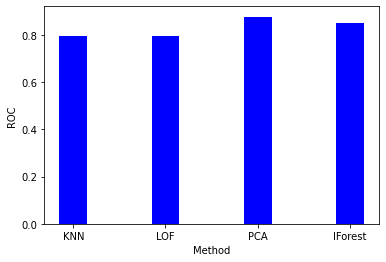

In [14]:
roc_mean=[ np.average(knn_roc), np.average(lof_roc), np.average(pca_roc), np.average(iforest_roc)]
name = ["KNN" , "LOF" , "PCA","IForest"]
plt.bar(name,roc_mean,width=0.3,color='blue')
plt.xlabel("Method")
plt.ylabel("ROC")
plt.show()

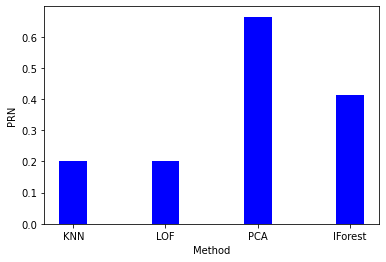

In [15]:
prn_mean=[ np.average(knn_prn), np.average(lof_prn), np.average(pca_prn), np.average(iforest_prn)]
name = ["KNN" , "LOF" , "PCA","IForest"]
plt.bar(name,prn_mean ,width=0.3,color='blue')
plt.xlabel("Method")
plt.ylabel("PRN")
plt.show()

我们可以看到，通过比较ROC和PRN可以发现，在数据集wine上，PCA的ROC和PRN值都比其他三种模型要高，效果更好